In [1]:
import torch
print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')

Torch version: 2.9.0+cu126
CUDA available: True
Device: Tesla T4


In [6]:
import zipfile

In [20]:
!pip install -q ultralytics lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
print('Files in /content:')
print(os.listdir('/content'))

Files in /content:
['.config', 'MaskFaceDataset.zip', 'drive', 'sample_data']


In [12]:
ZIP_PATH = '/content/MaskFaceDataset.zip'
if os.path.exists(ZIP_PATH):
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        print('Listing sample files:')
        for i, f in enumerate(z.namelist()[:20]):
            print(f)
        z.extractall('/content/MaskFaceDataset')
        print('Extracted to /content/MaskFaceDataset')
else:
    print('ZIP not found at', ZIP_PATH, ' — if you mounted Drive, update ZIP_PATH')

Listing sample files:
annotations/maksssksksss0.xml
annotations/maksssksksss1.xml
annotations/maksssksksss10.xml
annotations/maksssksksss100.xml
annotations/maksssksksss101.xml
annotations/maksssksksss102.xml
annotations/maksssksksss103.xml
annotations/maksssksksss104.xml
annotations/maksssksksss105.xml
annotations/maksssksksss106.xml
annotations/maksssksksss107.xml
annotations/maksssksksss108.xml
annotations/maksssksksss109.xml
annotations/maksssksksss11.xml
annotations/maksssksksss110.xml
annotations/maksssksksss111.xml
annotations/maksssksksss112.xml
annotations/maksssksksss113.xml
annotations/maksssksksss114.xml
annotations/maksssksksss115.xml
Extracted to /content/MaskFaceDataset


In [13]:
BASE = '/content/MaskFaceDataset'
IMG_DIR = os.path.join(BASE, 'images')
ANN_DIR = os.path.join(BASE, 'annotations')


print('IMG_DIR exists?', os.path.exists(IMG_DIR))
print('ANN_DIR exists?', os.path.exists(ANN_DIR))
print('Example images (first 10):', os.listdir(IMG_DIR)[:10])
print('Example annotations (first 10):', os.listdir(ANN_DIR)[:10])

IMG_DIR exists? True
ANN_DIR exists? True
Example images (first 10): ['maksssksksss616.png', 'maksssksksss544.png', 'maksssksksss87.png', 'maksssksksss607.png', 'maksssksksss397.png', 'maksssksksss605.png', 'maksssksksss557.png', 'maksssksksss842.png', 'maksssksksss328.png', 'maksssksksss307.png']
Example annotations (first 10): ['maksssksksss844.xml', 'maksssksksss513.xml', 'maksssksksss198.xml', 'maksssksksss89.xml', 'maksssksksss454.xml', 'maksssksksss385.xml', 'maksssksksss24.xml', 'maksssksksss423.xml', 'maksssksksss550.xml', 'maksssksksss575.xml']


In [16]:
import xml.etree.ElementTree as ET
from pathlib import Path


OUT_LABEL_DIR = os.path.join(BASE, 'labels')
Path(OUT_LABEL_DIR).mkdir(parents=True, exist_ok=True)


# Update classes if needed
CLASSES = ['with_mask', 'without_mask']


def convert_bbox(size, box):
    # size: (width, height)
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    xmin, xmax, ymin, ymax = box
    x = (xmin + xmax) / 2.0
    y = (ymin + ymax) / 2.0
    w = xmax - xmin
    h = ymax - ymin
    return x*dw, y*dh, w*dw, h*dh


ann_files = [f for f in os.listdir(ANN_DIR) if f.endswith('.xml')]
print('Found', len(ann_files), 'annotation XML files')


skipped = 0
for xml_file in ann_files:
    path = os.path.join(ANN_DIR, xml_file)
    tree = ET.parse(path)
    root = tree.getroot()
    filename = root.find('filename').text
    if not filename:
        # Sometimes filename tag is absent or stored differently; fallback to xml name
        filename = xml_file.replace('.xml', '.png')


    size = root.find('size')
    if size is None:
        # skip if no size info
        skipped += 1
        continue
    w = int(size.find('width').text)
    h = int(size.find('height').text)


    out_txt = os.path.join(OUT_LABEL_DIR, filename.replace('.png', '.txt').replace('.jpg', '.txt'))
    lines = []
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        if cls_name not in CLASSES:
            # skip unknown class (or alternatively: add it)
            # print('Skipping class', cls_name)
            continue
        cls_id = CLASSES.index(cls_name)
        xmlbox = obj.find('bndbox')
        xmin = float(xmlbox.find('xmin').text)
        ymin = float(xmlbox.find('ymin').text)
        xmax = float(xmlbox.find('xmax').text)
        ymax = float(xmlbox.find('ymax').text)
        x, y, bw, bh = convert_bbox((w, h), (xmin, xmax, ymin, ymax))
        lines.append(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")


    if lines:
        with open(out_txt, 'w') as f:
            f.writelines(lines)


print('Conversion done. Skipped', skipped, 'files without size or objects')
print('Labels saved to', OUT_LABEL_DIR)

Found 853 annotation XML files
Conversion done. Skipped 0 files without size or objects
Labels saved to /content/MaskFaceDataset/labels


In [18]:
import random
from shutil import copyfile


R = '/content/dataset'
for s in ['images/train','images/val','images/test','labels/train','labels/val','labels/test']:
    Path(os.path.join(R, s)).mkdir(parents=True, exist_ok=True)


all_images = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_images.sort()
random.seed(42)
random.shuffle(all_images)


n = len(all_images)
train_end = int(0.7*n)
val_end = int(0.85*n)


for i, img in enumerate(all_images):
    name = img
    label_name = img.replace('.png', '.txt').replace('.jpg', '.txt')
    if i < train_end:
        split = 'train'
    elif i < val_end:
        split = 'val'
    else:
        split = 'test'


    copyfile(os.path.join(IMG_DIR, img), os.path.join(R, 'images', split, img))
    src_label = os.path.join(OUT_LABEL_DIR, label_name)
    dst_label = os.path.join(R, 'labels', split, label_name)
    if os.path.exists(src_label):
        copyfile(src_label, dst_label)
    else:
        # if no label file, create empty label (no objects)
        open(dst_label, 'w').close()


print('Dataset split done.')
print('Counts:')
for s in ['train','val','test']:
    imgs = len(os.listdir(os.path.join(R, 'images', s)))
    lbls = len(os.listdir(os.path.join(R, 'labels', s)))
    print(s, 'images:', imgs, 'labels:', lbls)

Dataset split done.
Counts:
train images: 597 labels: 597
val images: 128 labels: 128
test images: 128 labels: 128


In [24]:
DATA_YAML = '/content/data.yaml'
with open(DATA_YAML, 'w') as f:
    f.write(f"train: {R}/images/train\n")
    f.write(f"val: {R}/images/val\n")
    f.write(f"test: {R}/images/test\n\n")
    f.write("nc: 2\n")
    f.write("names: ['with_mask','without_mask']\n")


print('Wrote', DATA_YAML)
print(open(DATA_YAML).read())

Wrote /content/data.yaml
train: /content/dataset/images/train
val: /content/dataset/images/val
test: /content/dataset/images/test

nc: 2
names: ['with_mask','without_mask']



In [25]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
results = model.train(data=DATA_YAML, epochs=30, imgsz=640, batch=16)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

In [27]:
from ultralytics import YOLO
import os

best_pt = '/content/runs/detect/train/weights/best.pt'

if os.path.exists(best_pt):
    model = YOLO(best_pt)
    metrics = model.val(data=DATA_YAML, imgsz=640)
    print(metrics)
else:
    print('No trained model found; run training cell first')

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3327.7±828.3 MB/s, size: 438.4 KB)
val: Scanning /content/dataset/labels/val.cache... 128 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 239.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.7it/s 4.6s
                   all        128        580      0.907      0.881      0.929      0.655
             with_mask        117        458      0.929      0.942      0.969      0.705
          without_mask         44        122      0.884       0.82      0.889      0.605
Speed: 3.1ms preprocess, 11.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultra

In [29]:
SAMPLE_IMG = os.path.join(R, 'images', 'test', os.listdir(os.path.join(R,'images','test'))[0])
print('Sample image:', SAMPLE_IMG)


if os.path.exists(best_pt):
    model = YOLO(best_pt)
    res = model.predict(source=SAMPLE_IMG, save=True, conf=0.35, imgsz=640)
    # res[0].plot() # plotting handled by save=True
    print('Saved prediction images in runs/detect/predict*')
else:
    print('Train first to get best.pt')

Sample image: /content/dataset/images/test/maksssksksss607.png

image 1/1 /content/dataset/images/test/maksssksksss607.png: 448x640 2 with_masks, 45.1ms
Speed: 1.7ms preprocess, 45.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/predict
Saved prediction images in runs/detect/predict*


In [31]:
from google.colab import files
if os.path.exists(best_pt):
    files.download(best_pt)
else:
    print('best.pt not found')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
print('Evaluating model on the test set...')
test_metrics = model.val(data=DATA_YAML, imgsz=640, split='test')
print(test_metrics)

Evaluating model on the test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2378.6±359.7 MB/s, size: 479.7 KB)
val: Scanning /content/dataset/labels/test... 128 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 955.8it/s 0.1s
val: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.5it/s 5.3s
                   all        128        535      0.896      0.869      0.924      0.647
             with_mask        116        461      0.931      0.902      0.959      0.695
          without_mask         41         74      0.861      0.835      0.889      0.598
Speed: 5.3ms preprocess, 10.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
bo

Visualizing predictions on sample test images:
Processing image: /content/dataset/images/test/maksssksksss463.png

image 1/1 /content/dataset/images/test/maksssksksss463.png: 640x608 (no detections), 17.6ms
Speed: 3.4ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)
No results found for /content/dataset/images/test/maksssksksss463.png
Processing image: /content/dataset/images/test/maksssksksss449.png

image 1/1 /content/dataset/images/test/maksssksksss449.png: 640x640 4 with_masks, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


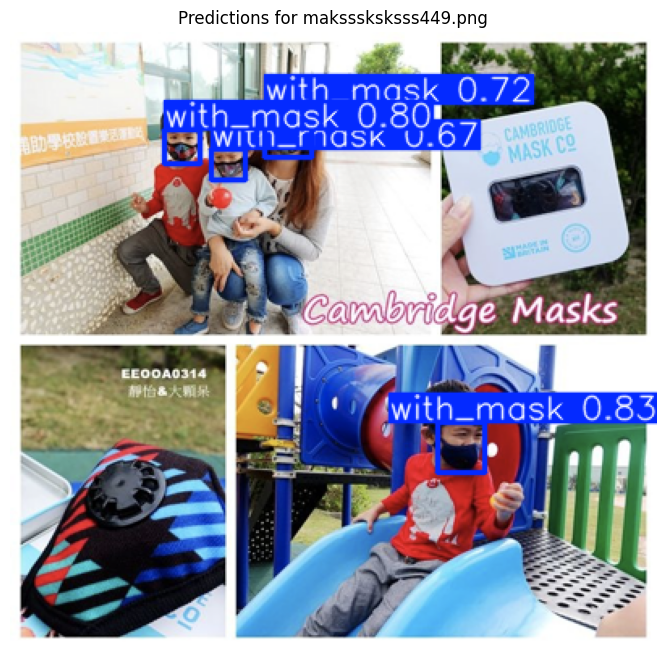

Processing image: /content/dataset/images/test/maksssksksss669.png

image 1/1 /content/dataset/images/test/maksssksksss669.png: 640x480 1 with_mask, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


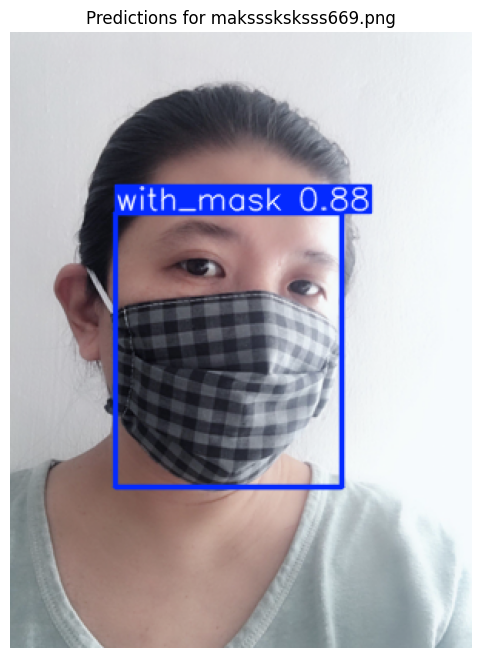

In [36]:
import random
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2

# Get a list of all test images
test_images_path = os.path.join(R, 'images', 'test')
all_test_images = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Select a few random images (e.g., 3 images)
random.seed(42) # for reproducibility
sample_test_images = random.sample(all_test_images, min(3, len(all_test_images)))

print('Visualizing predictions on sample test images:')
if os.path.exists(best_pt):
    model = YOLO(best_pt)
    for img_path in sample_test_images:
        print(f'Processing image: {img_path}')
        # Perform prediction without saving to disk initially
        results = model.predict(source=img_path, conf=0.35, imgsz=640)

        if results and results[0]:
            # Get the annotated image as a numpy array directly
            im_array = results[0].plot()  # plot() returns a BGR numpy array
            # Convert BGR to RGB for matplotlib
            im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 8))
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"Predictions for {os.path.basename(img_path)}")
            plt.show()
        else:
            print(f"No results found for {img_path}")
else:
    print('No trained model found; run training cell first')